In [1]:
# Dependencies and Setup
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps

from sodapy import Socrata
low_memory = False
from pandas.api.types import CategoricalDtype


In [2]:
# State wide Covid-19 vaccines administered by county 
csv_data = pd.read_csv("./statewide-covid-19-vaccines-administered-by-county.csv")
ca_vaccin_data_all = csv_data.query('county =="All CA Counties"')

# Creating a dataframe with selected columns
ca_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','total_doses','pfizer_doses',\
                                                         'moderna_doses','jj_doses','partially_vaccinated',\
                                                         'fully_vaccinated'])

# Creating dataframe for cumulative vaccination (using for cummulative line graphs)
cumulative_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','cumulative_total_doses',\
                                                         'total_partially_vaccinated','cumulative_fully_vaccinated'])


# Converting the string format of date into datetime and created a new column for month
ca_vaccin_data['month'] = pd.DatetimeIndex(ca_vaccin_data['administered_date']).month_name()

# Creating a new dataframe with months as variable to be utilized for ploting by months
ca_vaccinated = pd.DataFrame(ca_vaccin_data, columns=['month','administered_date','fully_vaccinated','partially_vaccinated'])


In [3]:
# Converting the order of months over time of the year (avoiding alphabatically ascending or descending order)
month = ca_vaccinated["month"]
values = ca_vaccinated['fully_vaccinated']
data = {
    'month' : [month],
    'value' : [values] }

month_order = CategoricalDtype(['December', 'January', 'February', 'March', 'April', \
                                'May', 'June', 'July', 'August'], ordered=True)

ca_vaccinated['month'] = ca_vaccinated['month'].astype(month_order)
# ca_vaccinated


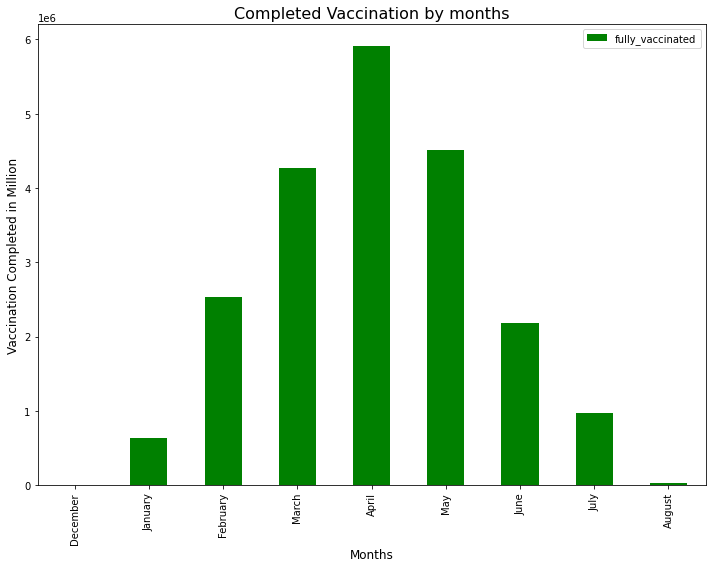

In [4]:
# Generating a bar plot showing the total number of completed vaccination by months
ca_vaccinated_completed = pd.DataFrame(ca_vaccinated, columns=['month','fully_vaccinated'])
ca_vaccinated_completed_montly = ca_vaccinated_completed.groupby(ca_vaccinated_completed['month']).sum()

bar_plot = ca_vaccinated_completed_montly.plot.bar(figsize=(10,8), color='g')
plt.xlabel("Months",fontsize = 12)
plt.ylabel("Vaccination Completed in Million",fontsize = 12)
plt.title("Completed Vaccination by months",fontsize = 16)

plt.tight_layout()

plt.savefig("./CA_completed_vaccination_by _months.png")
plt.show()

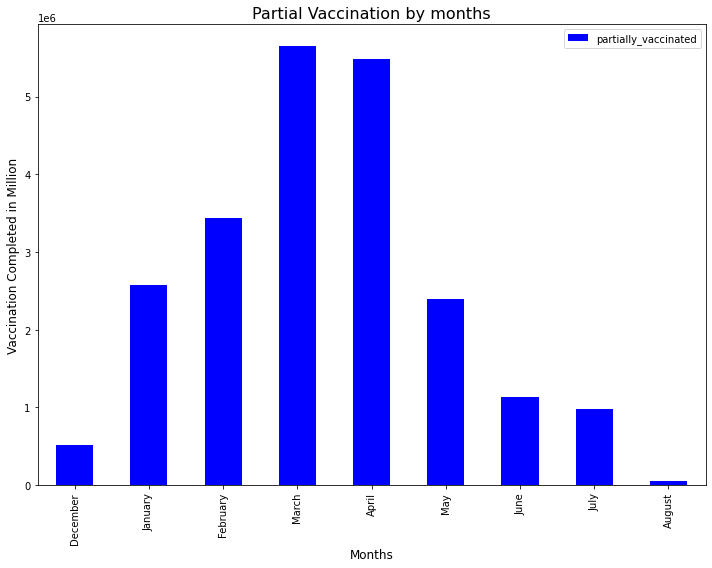

In [5]:
# Generate a bar plot showing the total number of partial vaccination by months

ca_vaccinated_partial = pd.DataFrame(ca_vaccinated, columns=['month','partially_vaccinated'])

ca_vaccinated_partial_montly = ca_vaccinated_partial.groupby(ca_vaccinated_partial['month']).sum()

bar_plot = ca_vaccinated_partial_montly.plot.bar(figsize=(10,8), color='b')

plt.xlabel("Months",fontsize = 12)
plt.ylabel("Vaccination Completed in Million",fontsize = 12)
plt.title("Partial Vaccination by months",fontsize = 16)

plt.tight_layout()
plt.show()

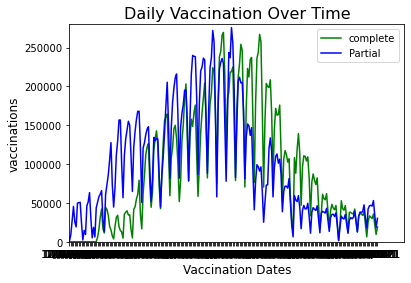

In [23]:
import matplotlib.pyplot as plt
import numpy as np

dates = ca_vaccinated['administered_date']
complete = ca_vaccinated['fully_vaccinated']
partial = ca_vaccinated['partially_vaccinated']

# Plot the charts and apply some styling

complete, = plt.plot(dates, complete, color="g", label="complete")
partial, = plt.plot(dates, partial, color="b", label="Partial")

# Add labels to X and Y axes :: Add title
plt.title("Daily Vaccination Over Time", fontsize = 16)
plt.xlabel("Vaccination Dates", fontsize = 12)
plt.ylabel("vaccinations", fontsize = 12)

# Set the limits for the X and Y axes
plt.xlim(0,250)
plt.ylim(0,280000)

# Create a legend for the chart
plt.legend(handles=[complete, partial], loc="best")
plt.show()

<AxesSubplot:>

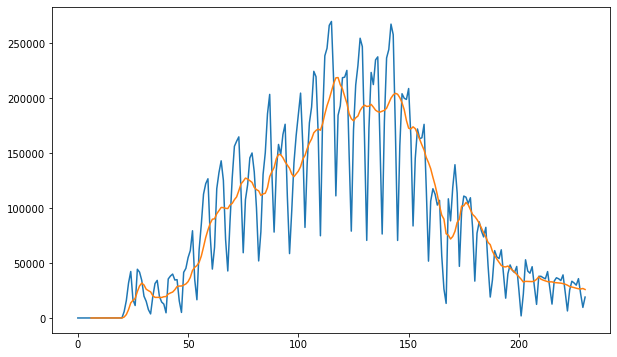

In [31]:
# Calculating 7 days moving average of complete vaccination

complete = ca_vaccinated['fully_vaccinated']
complete.plot(figsize=(10,6))
complete.rolling(window =7).mean().plot()


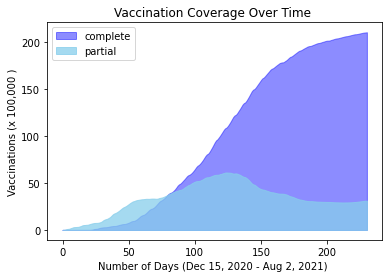

In [7]:
# Cumulative_vaccin_data for plotting vaccination coverage over time

dates = cumulative_vaccin_data['administered_date']
complete = cumulative_vaccin_data['cumulative_fully_vaccinated']/100000
partial = cumulative_vaccin_data['total_partially_vaccinated']/100000

# Plot the charts and apply some styling
plt.fill_between(np.arange(231), complete, color="blue", alpha=0.45, label='complete')
plt.fill_between(np.arange(231), partial, color="skyblue", alpha=0.75, label='partial')

plt.title("Vaccination Coverage Over Time ")
plt.xlabel("Number of Days (Dec 15, 2020 - Aug 2, 2021) ")
plt.ylabel("Vaccinations (x 100,000 )")

plt.legend(loc="upper left")
plt.show()

In [167]:
# Selecting only the residence county as reported in the data (elemination method is used)
ca_vaccin_data = csv_data.query('county !="All CA Counties"')
ca_vaccin_data = ca_vaccin_data.query('county !="All CA and Non-CA Counties"')
ca_vaccin_data = ca_vaccin_data.query('county !="Outside California"')
ca_vaccin_data = ca_vaccin_data.query('county !="Unknown"')

# getting new dataframe for total vaccination (fully and partially vaccinated) by counties

county_vac_data = ca_vaccin_data.groupby(ca_vaccin_data['county']).sum()

county_vac_data= pd.DataFrame(county_vac_data, columns =['partially_vaccinated', 'fully_vaccinated']).sort_values(by = \
                                                        'fully_vaccinated', ascending = False) 
# county_vac_data


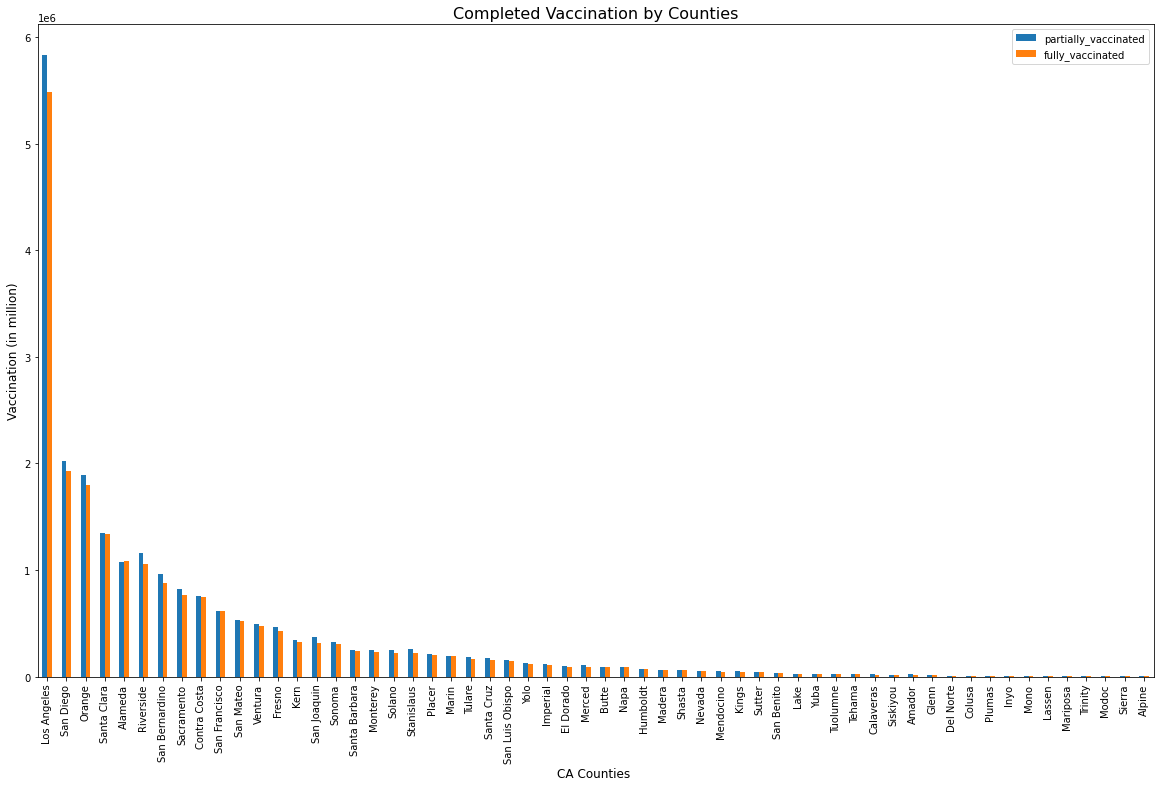

In [168]:
county_vac_data.plot(y = ['partially_vaccinated', 'fully_vaccinated'], kind='bar', figsize=(20,12))  #.bar(figsize=(16,9), color='g', alpha = 0.75)

plt.xlabel("CA Counties ",fontsize = 12)
plt.ylabel("Vaccination (in million)",fontsize = 12)
plt.title("Completed Vaccination by Counties",fontsize = 16)
plt.show()


In [171]:
# Reading the data file for population by county
pop_data = pd.read_csv("./CA_county_pop.csv") # Source: https://www.california-demographics.com/counties_by_population
pop_data = pd.DataFrame(pop_data)

county = []
county_name = pop_data['County']
for i in county_name:
        size = len(i)
        mod_name = i[:size-7]
        county.append(mod_name)

pop_data['county'] = county
county_pop_data = pop_data[['county', 'Population']]
pop = pop_data['Population']

county_pop_vac_data.to_csv("./CA_county_population_and_vaccination_data.csv", index=False)

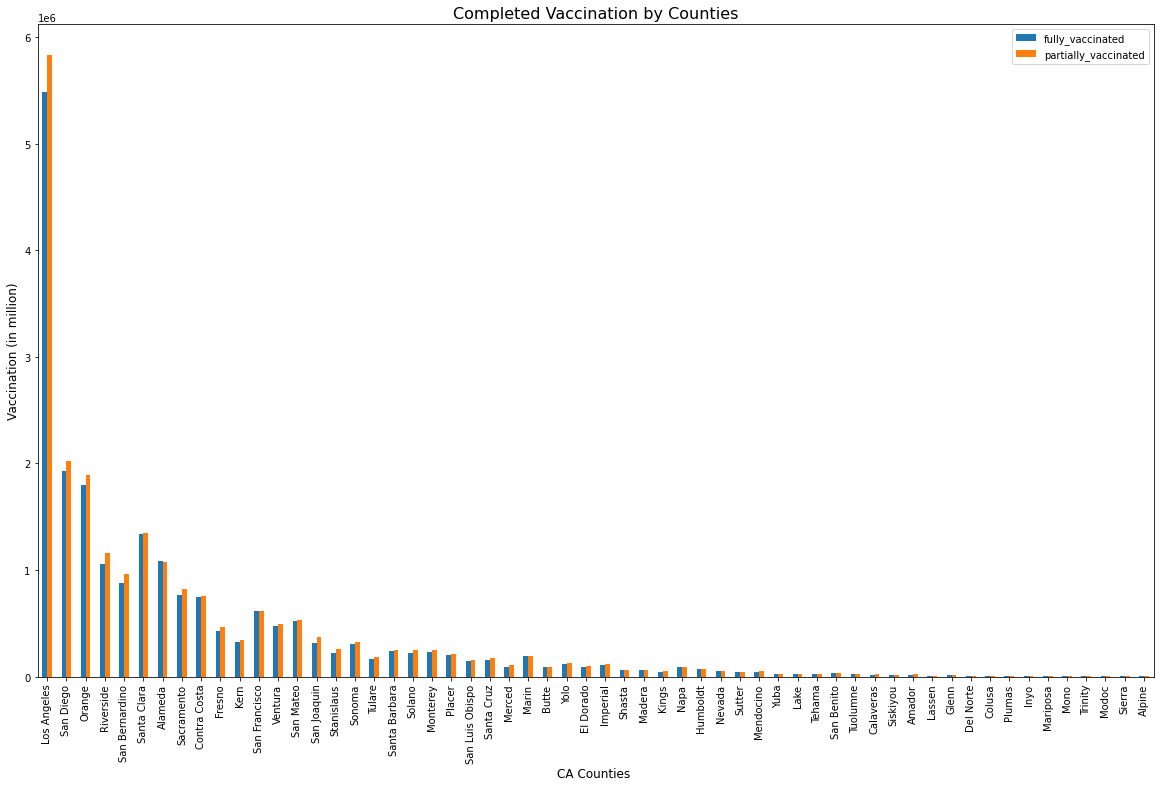

In [170]:
county_pop_vac_data = pd.merge(county_pop_data, county_vac_data, on = 'county', how = 'left')

county_pop_vac_data.plot(x="county", y = ['fully_vaccinated' ,'partially_vaccinated', 'Population'], kind="bar", figsize=(20,12))

plt.xlabel("CA Counties ",fontsize = 12)
plt.ylabel("Vaccination (in million)",fontsize = 12)
plt.title("Completed Vaccination by Counties",fontsize = 16)
plt.show()



,county,Population,partially_vaccinated,fully_vaccinated
0,Los Angeles,"10,081,570",5828030,5484678
1,San Diego,"3,316,073",2018518,1927095
2,Orange,"3,168,044",1886156,1796692
3,Riverside,"2,411,439",1156004,1054074
4,San Bernardino,"2,149,031",957518,878368
5,Santa Clara,"1,927,470",1351031,1333873
6,Alameda,"1,656,754",1072682,1080140
7,Sacramento,"1,524,553",824223,769056
8,Contra Costa,"1,142,251",756072,747826
9,Fresno,"984,521",462204,423906
